# LSTM CON DF TRANSACCIONES


Ejemplo LSTM - https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, datetime
import math
import warnings
from matplotlib import style
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

Using TensorFlow backend.


In [2]:
%pylab inline
%matplotlib inline
style.use('ggplot')
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
pathCSV = "http://dreamlife.es/ripple.csv"
pathCSV ="C:\\Users\\juan.roncero\\Desktop\\Master ML\\Proyecto Final\\Data\\ripple29Mayo.csv"
dfTransacciones = pd.read_csv(pathCSV,delimiter=";", decimal=",")
dfTransacciones.head(1)

,AMOUNT,FECHA,TIMESPAN,PRICE,TID,TIPOTRANSACCION,ID_MONEDA
0,954.384771,2018-02-18 11:29:34,1518949774,1.07,55346698,False,5


In [4]:
# INDICE
dfTransacciones["FECHA"] = pd.to_datetime(dfTransacciones["FECHA"])
dfTransacciones.index = pd.to_datetime(dfTransacciones["FECHA"], unit='s')

In [5]:
df = dfTransacciones
dfCompras = dfTransacciones[dfTransacciones["TIPOTRANSACCION"]==False]
dfVentas = dfTransacciones[dfTransacciones["TIPOTRANSACCION"]==True]

# NUEVAS COLUMNAS
df["HIGH"] = df["PRICE"]
df['LOW'] = df["PRICE"]
#df["OPEN"] = df["OPEN"]
#df['CLOSE'] = df["CLOSE"]
df['CANTIDAD_TOTAL'] = df["AMOUNT"]
dfCompras['NUM_T_COMPRA'] = dfCompras["AMOUNT"]
dfVentas['NUM_T_VENTA'] = dfVentas["AMOUNT"]

# MAXIMO, MINIMO, CANTIDAD_TOTAL
df1 = df.groupby(pd.Grouper(key='FECHA', freq="30Min")).agg({'HIGH':np.max, 'LOW':np.min,'CANTIDAD_TOTAL':np.sum})

# NÚMERO DE TRANSACCIONES DE COMPRA
df2 = dfCompras.groupby(pd.Grouper(key='FECHA', freq="30Min")).count()
df2 = df2['NUM_T_COMPRA']

# NÚMERO DE TRANSACCIONES DE VENTA
df3 = dfVentas.groupby(pd.Grouper(key='FECHA', freq="30Min")).count()
df3 = df3['NUM_T_VENTA']

# CANTIDAD TOTAL DE MONEDA COMPRADA
df4 = dfCompras.groupby(pd.Grouper(key='FECHA', freq="30Min")).sum() 
df4["CANTIDAD_COMPRA"] = df4['AMOUNT']
df4 = df4['CANTIDAD_COMPRA']

# CANTIDAD TOTAL DE MONEDA VENDIDA
df5 = dfVentas.groupby(pd.Grouper(key='FECHA', freq="30Min")).sum()
df5["CANTIDAD_VENTA"] = df5['AMOUNT']
df5 = df5['CANTIDAD_VENTA']

# OPEN
df6 = df.groupby(pd.Grouper(key='FECHA', freq="30Min")).first()
df6["OPEN"] = df6["PRICE"]
df6= df6["OPEN"]

# CLOSE
df7 = df.groupby(pd.Grouper(key='FECHA', freq="30Min")).last()
df7["CLOSE"] = df7["PRICE"]
df7= df7["CLOSE"]

df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)

# NUEVAS COLUMNAS CALCULADAS
df['VAR'] = (df['HIGH'] - df['LOW'])/df['LOW'] * 100
df['DIF_DIA'] = (df['CLOSE'] - df['OPEN'])/df['OPEN'] * 100

# FILTRAMOS COLUMNAS 
df = df[['NUM_T_COMPRA','NUM_T_VENTA','CANTIDAD_COMPRA','CANTIDAD_VENTA','VAR','DIF_DIA','CLOSE']]

df = df.dropna()

df.head(3)

,NUM_T_COMPRA,NUM_T_VENTA,CANTIDAD_COMPRA,CANTIDAD_VENTA,VAR,DIF_DIA,CLOSE
FECHA,,,,,,,
2018-02-18 01:00:00,36,113,52332.235542,204701.514742,1.206024,-0.173504,1.16797
2018-02-18 01:30:00,203,28,428859.094852,42760.221449,0.850034,0.256849,1.17100
2018-02-18 02:00:00,111,90,105115.316973,117199.070627,0.636752,0.228156,1.17292


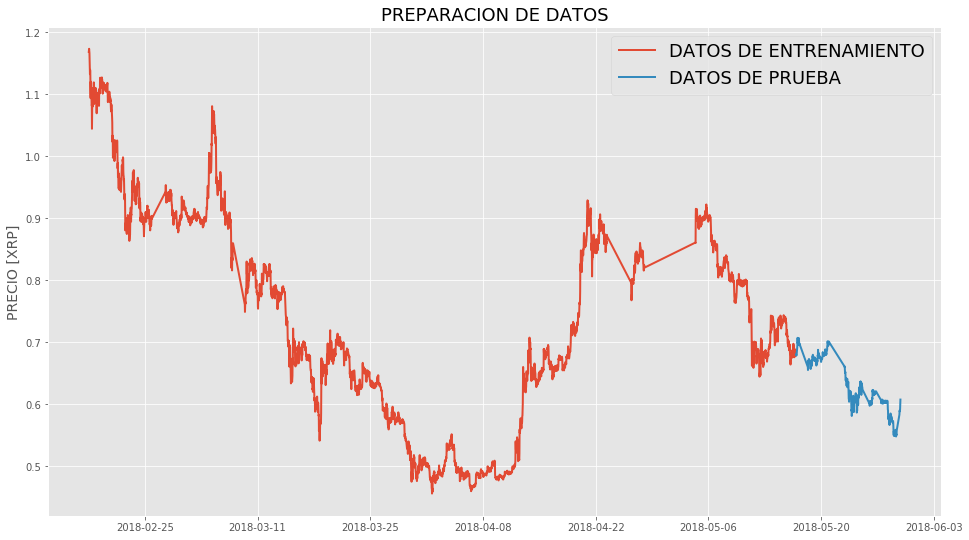

In [6]:
test_size=0.1
split_row = len(df) - int(test_size * len(df))
train_data = df.iloc[:split_row]
test_data = df.iloc[split_row:]

fig, ax = plt.subplots(1, figsize=(16, 9))
ax.plot(train_data.CLOSE, label="DATOS DE ENTRENAMIENTO", linewidth=2)
ax.plot(test_data.CLOSE, label="DATOS DE PRUEBA", linewidth=2)
ax.set_ylabel('PRECIO [XRP]', fontsize=14)
ax.set_title("PREPARACION DE DATOS", fontsize=18)
ax.legend(loc='best', fontsize=18)


In [7]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1

def extract_window_data(df, window=7):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [8]:
df.head()

,NUM_T_COMPRA,NUM_T_VENTA,CANTIDAD_COMPRA,CANTIDAD_VENTA,VAR,DIF_DIA,CLOSE
FECHA,,,,,,,
2018-02-18 01:00:00,36,113,52332.235542,204701.514742,1.206024,-0.173504,1.16797
2018-02-18 01:30:00,203,28,428859.094852,42760.221449,0.850034,0.256849,1.17100
2018-02-18 02:00:00,111,90,105115.316973,117199.070627,0.636752,0.228156,1.17292
2018-02-18 02:30:00,36,92,32214.649095,107239.826570,0.813196,-0.456827,1.17013
2018-02-18 03:00:00,66,141,19158.535265,151231.347337,1.077330,-0.352098,1.16601


In [11]:
window = 7
X_train = extract_window_data(train_data, window)
X_test = extract_window_data(test_data, window)

In [ ]:
# 3616 len(X_train)
#  395 len(X_test)
# 3616 len(y_train)
#  395 len(y_test)

In [ ]:
# X_train (valores normalizados de todos los datos)

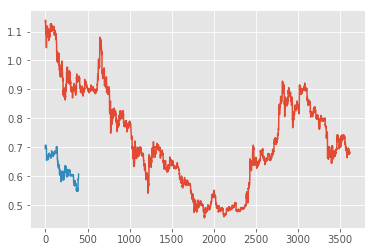

In [12]:
y_train = train_data.CLOSE[window:].values
y_test = test_data.CLOSE[window:].values

plt.plot(y_train)
plt.plot(y_test)

In [13]:
# Normalizamos
y_train = y_train / train_data.CLOSE[:-window].values - 1
y_test = y_test / test_data.CLOSE[:-window].values - 1

In [14]:
split_row = len(df) - int(test_size * len(df))
train_data = df.iloc[:split_row]
test_data = df.iloc[split_row:]

def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1


In [15]:
import json
import requests
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-01-10,14.14,14.32,13.77,13.77,51811.03,727790.48
2013-01-11,14.14,14.35,13.91,14.14,40434.54,570677.27
2013-01-12,14.24,14.34,13.98,14.14,26931.84,381546.96
2013-01-13,14.12,14.31,13.95,14.24,38330.15,540759.58
2013-01-14,14.30,14.35,14.11,14.12,22096.95,315016.66


In [16]:
# extract window data
X_train = extract_window_data(train_data, window)
X_test = extract_window_data(test_data, window)

# extract targets
y_train = train_data.CLOSE[window:].values
y_test = test_data.CLOSE[window:].values

y_train = y_train / train_data.CLOSE[:-window].values - 1
y_test = y_test / test_data.CLOSE[:-window].values - 1

In [17]:
# PARÁMETROS MODELO
neurons=20
activ_func='linear'
dropout=0.25
loss='mae' 
optimizer='adam'


In [18]:
model = Sequential()

model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(Dense(units=1))
model.add(Activation(activ_func))

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=50, batch_size=4)

Epoch 1/50
3616/3616 [==============================] - 4s 1ms/step - loss: nan
Epoch 2/50
3616/3616 [==============================] - 4s 1ms/step - loss: nan
Epoch 3/50
3616/3616 [==============================] - 5s 1ms/step - loss: nan
Epoch 4/50
3616/3616 [==============================] - 5s 1ms/step - loss: nan
Epoch 5/50
3616/3616 [==============================] - 5s 1ms/step - loss: nan
Epoch 6/50
3616/3616 [==============================] - 4s 1ms/step - loss: nan
Epoch 7/50
3616/3616 [==============================] - 4s 1ms/step - loss: nan
Epoch 8/50
3616/3616 [==============================] - 5s 1ms/step - loss: nan
Epoch 9/50
3616/3616 [==============================] - 4s 1ms/step - loss: nan
Epoch 10/50
3616/3616 [==============================] - 5s 1ms/step - loss: nan
Epoch 11/50
3616/3616 [==============================] - 5s 1ms/step - loss: nan
Epoch 12/50
3616/3616 [==============================] - 5s 1ms/step - loss: nan
Epoch 13/50
3616/3616 [==============

In [69]:
preds = model.predict(X_test).squeeze()

In [70]:
preds

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n